# Neural Network Classification with Pytorch

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles
# Make 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First five samples of X: {X[:5]}")
print(f"First five samples of y: {y[:5]}")

First five samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples of y: [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2" : X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

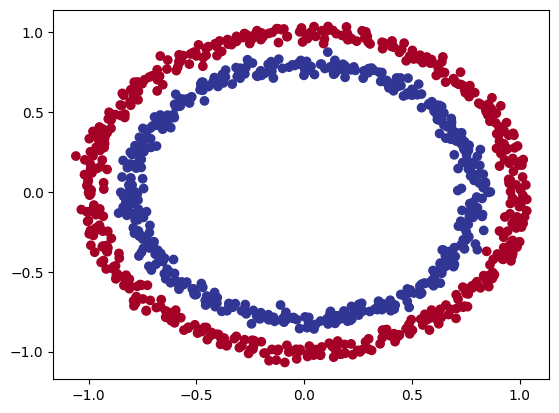

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as toy dataset, a dataset that is small enough to experiment on but still sizable to practice the fundamentals.

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'2.4.0+cu124'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X),X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of the data will be test & 80% will be train
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic let's create a model:
1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling shapes of our data
3. Define a `forward()` method that outlines the forward pass of the model
4. Instatiate an instance of our model class and send it to the target device

In [17]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features and outputs a single feature
        # two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # ).to(device)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
        # return two_linear_layers

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5845, -0.2484],
                      [ 0.2463, -0.5940],
                      [-0.4170,  0.0378],
                      [-0.1200,  0.6501],
                      [ 0.4383,  0.4664]], device='cuda:0')),
             ('0.bias',
              tensor([-0.1869,  0.6437,  0.5676,  0.1395,  0.1706], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3501, -0.1393,  0.2259,  0.3671, -0.0343]], device='cuda:0')),
             ('1.bias', tensor([0.2786], device='cuda:0'))])

In [21]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.4457],
        [0.5153],
        [0.2137],
        [0.5116],
        [0.1351],
        [0.1782],
        [0.4365],
        [0.3574],
        [0.2174],
        [0.5191]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should we use?

This is problem specific.
For example for regression we might want MAE or MSE (mean absolute error or mean squared error)
For classification we might want binary cross entropy or categorical cross entropy

As for optimizer two most common and useful are SGD and Adam

In [22]:
# setup the loss funtions
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [23]:
# Calculate Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Train model

To train our model, we're going to build a training loop with following steps:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of 
activation function (eg. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [24]:
# view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4457],
        [0.5153],
        [0.2137],
        [0.5116],
        [0.1351]], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# use sigmoid activation function on logits to turn them into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6096],
        [0.6260],
        [0.5532],
        [0.6252],
        [0.5337]], device='cuda:0')

For our prediction probability values we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)
# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

## 3.2 Building the training loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# set number of epochs
epochs = 100
# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    # forward_pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    # calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    # optimizer zero grad
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    # optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    # print
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.7051936388015747, Acc: 50.00% | Test loss: 0.71269, Test acc: 50.00%
Epoch: 10 | Loss: 0.7041147947311401, Acc: 50.00% | Test loss: 0.71154, Test acc: 50.00%
Epoch: 20 | Loss: 0.7031408548355103, Acc: 50.00% | Test loss: 0.71049, Test acc: 50.00%
Epoch: 30 | Loss: 0.7022615075111389, Acc: 50.00% | Test loss: 0.70954, Test acc: 50.00%
Epoch: 40 | Loss: 0.7014672756195068, Acc: 50.00% | Test loss: 0.70867, Test acc: 50.00%
Epoch: 50 | Loss: 0.7007496356964111, Acc: 50.50% | Test loss: 0.70788, Test acc: 50.00%
Epoch: 60 | Loss: 0.7001011371612549, Acc: 53.25% | Test loss: 0.70716, Test acc: 51.00%
Epoch: 70 | Loss: 0.699514627456665, Acc: 55.75% | Test loss: 0.70650, Test acc: 54.00%
Epoch: 80 | Loss: 0.6989842057228088, Acc: 57.25% | Test loss: 0.70590, Test acc: 56.00%
Epoch: 90 | Loss: 0.6985040307044983, Acc: 58.25% | Test loss: 0.70536, Test acc: 56.50%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model is not learning anything

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

In [29]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_fucntions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    print("Download complete \nWriting to file helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    print("Done")

from helper_functions import plot_predictions, plot_decision_boundary

helper_fucntions.py already exists, skipping download


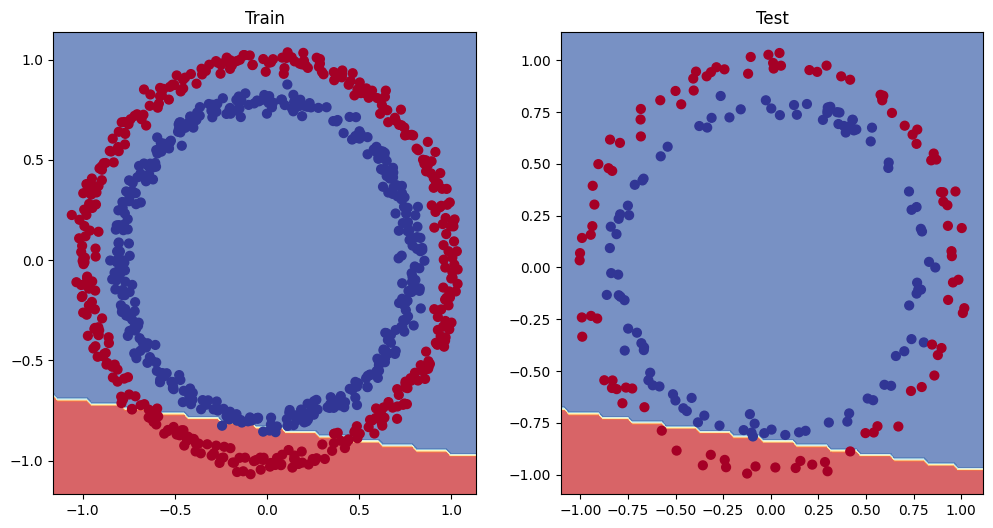

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from model perspective)

* Add more layers - give the model more chances to learn about patterns in the data.
* Add more hidden units (neurons)
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we can change they are referred to as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

Generally when doing experimentation we change only one of these at a time

In [31]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5847, -0.2541],
                      [ 0.2463, -0.5916],
                      [-0.4169,  0.0345],
                      [-0.1198,  0.6444],
                      [ 0.4382,  0.4671]])),
             ('0.bias', tensor([-0.2072,  0.6523,  0.5557,  0.1192,  0.1730])),
             ('1.weight',
              tensor([[ 0.3656, -0.1665,  0.1933,  0.3494, -0.0512]])),
             ('1.bias', tensor([0.2219]))])

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes.

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [34]:
# Create loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [35]:
# Write training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# device agnostics for data
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# no of epochs
epochs = 1000
## Training
for epoch in range(epochs):
    # set model to training
    model_1.train()
    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    # calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)
    # optimizer zero grad
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    # optimizer step
    optimizer.step()
    ## evaluation
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_preds)
    # Print
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}$ | Test loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.69396, Acc: 50.88$ | Test loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38$ | Test loss: 0.69379, Test Acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12$ | Test loss: 0.69437, Test Acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62$ | Test loss: 0.69458, Test Acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12$ | Test loss: 0.69465, Test Acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00$ | Test loss: 0.69467, Test Acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00$ | Test loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00$ | Test loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00$ | Test loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00$ | Test loss: 0.69468, Test Acc: 46.00%


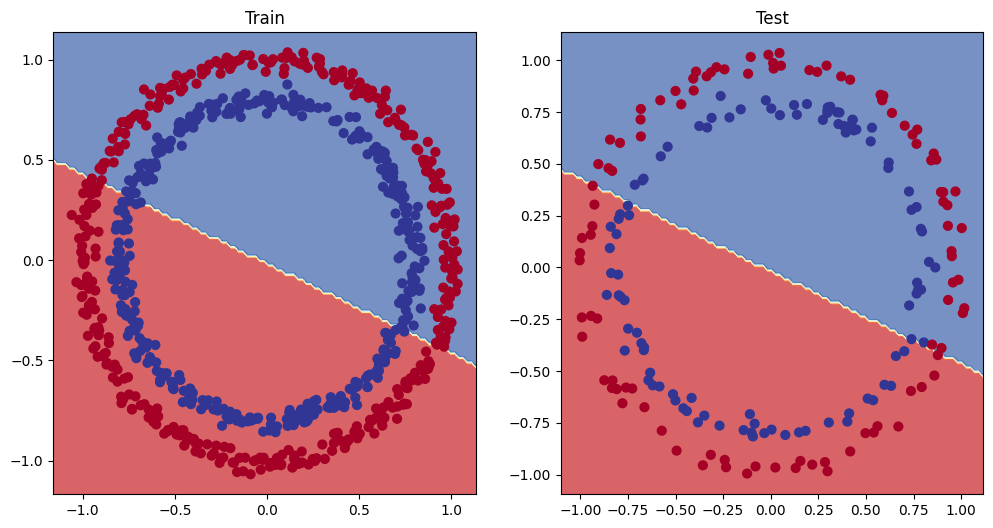

In [36]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [37]:
# Create data
weight = 0.7
bias = 0.3
start =0
end= 1
step=0.01
X_reg = torch.arange(start, end, step).unsqueeze(dim=1)
y_reg = weight * X_reg + bias
X_reg[:5], y_reg[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
# Create train and test split
train_split = int(0.8*len(X_reg))
X_train_reg, y_train_reg = X_reg[:train_split], y_reg[:train_split]
X_test_reg, y_test_reg = X_reg[train_split:], y_reg[train_split:]

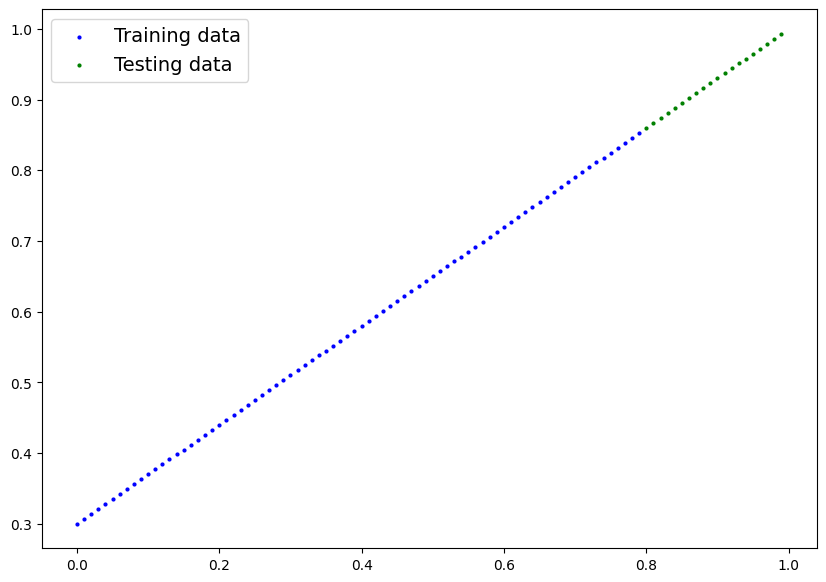

In [39]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg)

### 5.2 Adjust model 1 to fit a straight line

In [40]:
# Same architecture as model_1 
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# device agnostics for data
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)
# no of epochs
epochs = 1000
## Training
for epoch in range(epochs):
    # set model to train
    model_2.train()
    # forward pass
    y_preds = model_2(X_train_reg)
    # calculate loss
    loss = loss_fn(y_preds, y_train_reg)
    # optimizer zero grad
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    # optimizer step
    optimizer.step()
    ## evaluation
    model_2.eval()
    with torch.inference_mode():
        # forward pass
        test_preds = model_2(X_test_reg)
        # calculate loss
        test_loss = loss_fn(test_preds, y_test_reg)
    # print
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | test_loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | test_loss: 0.91103
Epoch: 100 | Loss: 0.02858 | test_loss: 0.00081
Epoch: 200 | Loss: 0.02533 | test_loss: 0.00209
Epoch: 300 | Loss: 0.02137 | test_loss: 0.00305
Epoch: 400 | Loss: 0.01964 | test_loss: 0.00341
Epoch: 500 | Loss: 0.01940 | test_loss: 0.00387
Epoch: 600 | Loss: 0.01903 | test_loss: 0.00379
Epoch: 700 | Loss: 0.01878 | test_loss: 0.00381
Epoch: 800 | Loss: 0.01840 | test_loss: 0.00329
Epoch: 900 | Loss: 0.01798 | test_loss: 0.00360


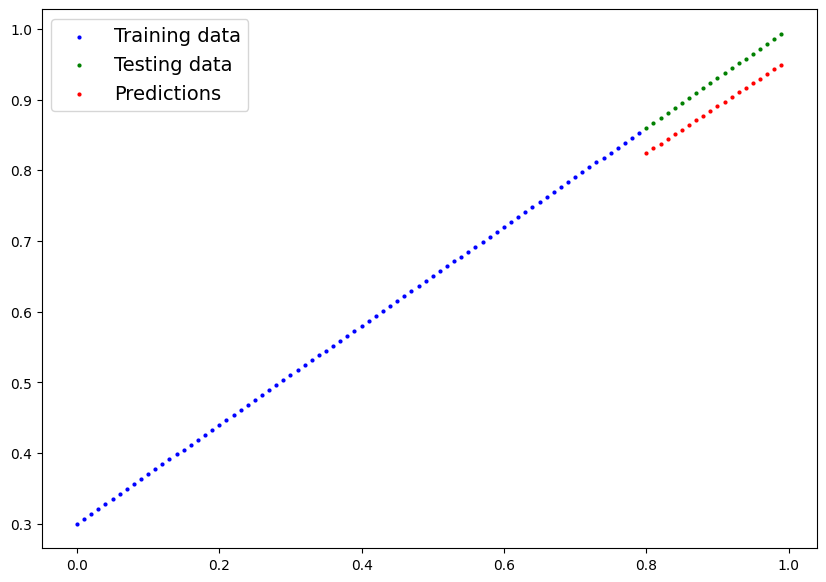

In [43]:
# turn on evaluation mode
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_reg)

plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

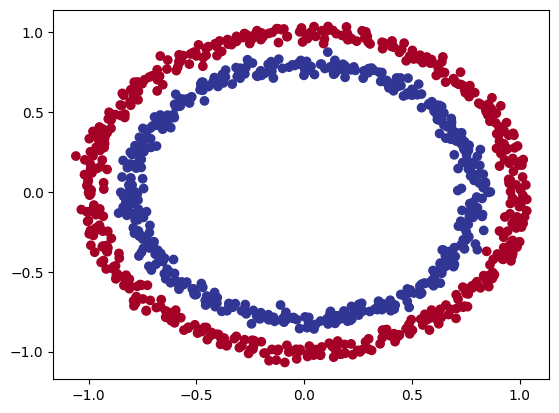

In [47]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [48]:
# convert data to tensors and then to train and test split
import torch
from sklearn.model_selection import train_test_split
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

Artificial neural networks are a large combination of linear and non-linear fucntions which are potentially able to find patterns in data.

In [53]:
# Build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
# setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [55]:
# setup manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# device agnostics for data
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# no of epochs
epochs = 1000
for epoch in range(epochs):
    # set model to train
    model_3.train()
    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    # optimizer zero grad
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    # optimizer step
    optimizer.step()
    # evaluation
    model_3.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    # print
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test Acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test Acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test Acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test Acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test Acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test Acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test Acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test Acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test Acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test Acc: 79.00%


In [57]:
### 6.4 Evaluating model with non-linear activation functions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

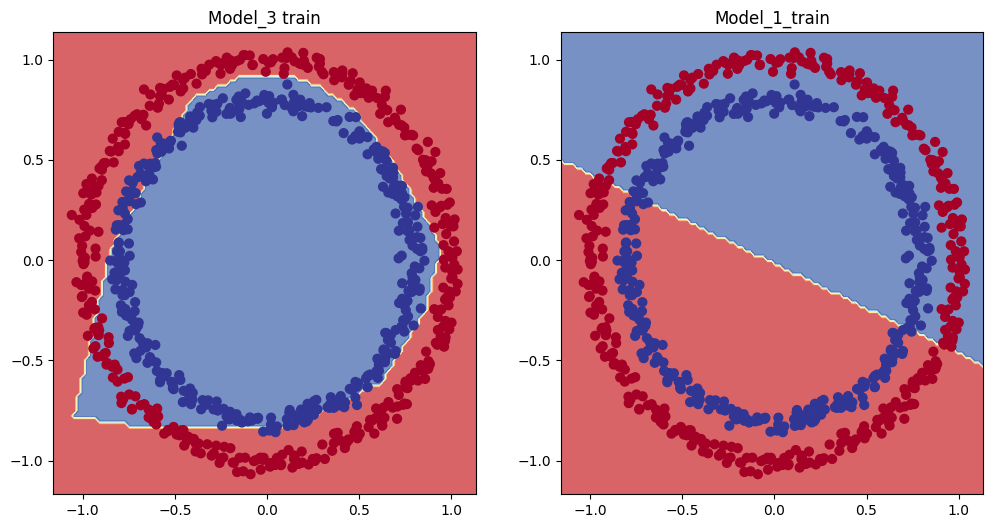

In [60]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Model_3 train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Model_1_train")
plot_decision_boundary(model_1, X_train, y_train)

## 7. Replicating non-linear activation fucntions

In [61]:
# create tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

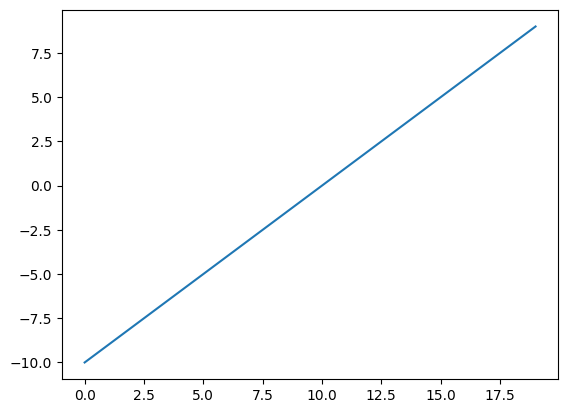

In [62]:
# visualize
plt.plot(A)

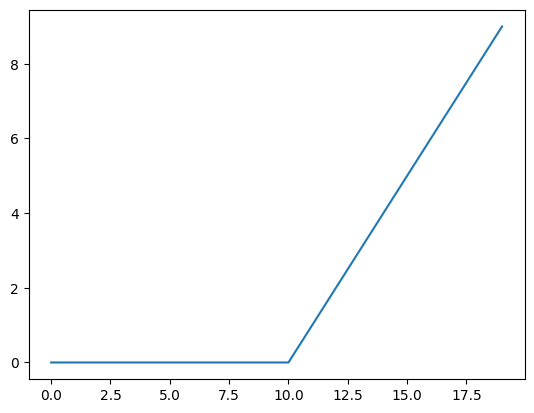

In [63]:
plt.plot(torch.relu(A))

In [65]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

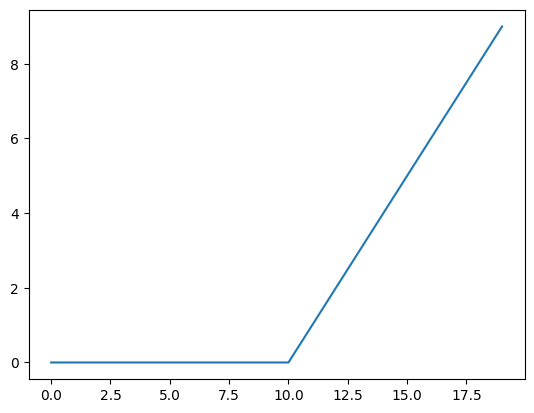

In [66]:
plt.plot(relu(A))

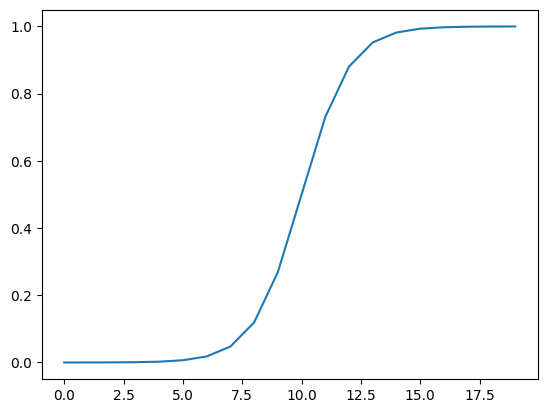

In [67]:
# Sigmoid
def sigmoid(x):
    return 1/(1+torch.exp(-A))

plt.plot(sigmoid(A))

## 8. Putting it together with a multi-class classification problem

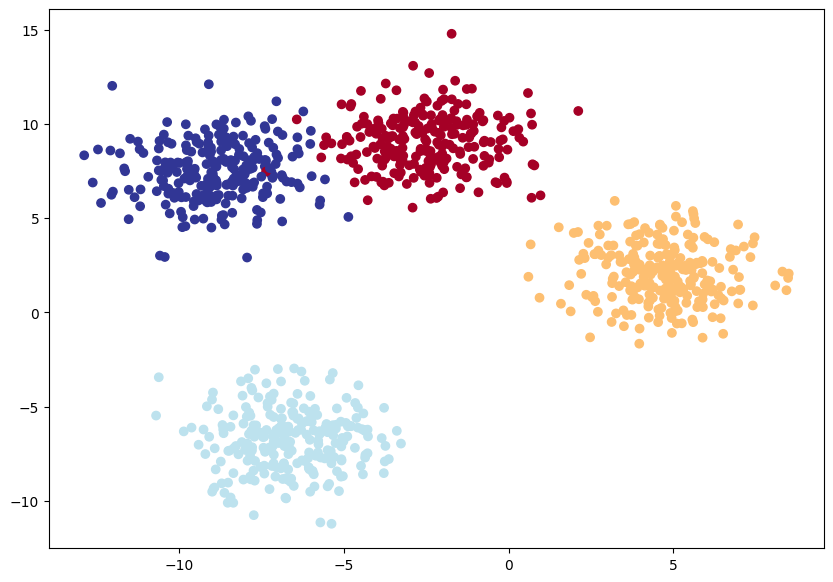

In [103]:
### 8.1 Creating a toy multi-class dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# setup hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# convert data to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# train test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [104]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [105]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initialize multi-class classification model

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8

        Returns:
            BlobModel(
              (linear_layer_stack): Sequential(
                (0): Linear(in_features=input_features, out_features=hidden_units, bias=True)
                (1): ReLU()
                (2): Linear(in_features=hidden_units, out_features=hidden_units, bias=True)
                (3): ReLU()
                (4): Linear(in_features=hidden_units, out_features=output_features, bias=True)
              )
            )
        Example:
            model = BlobModel(input_features=2, 
                    output_features=4,
                    hidden_units=8)
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
            return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2, 
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [106]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [107]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and optimizer for multi-class classification

In [108]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probablilities for multi-class PyTorch model

In [109]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [110]:
y_blob_train[:10]

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0])

In [111]:
# convert out model's logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [112]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [113]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [114]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [115]:
# convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 0, 0, 0, 0], device='cuda:0')

In [116]:
y_blob_train[:5]

tensor([1, 0, 2, 2, 0])

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [117]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# set no of epochs
epochs=100
# put data on target device
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device),X_blob_test.to(device),y_blob_train.to(device),y_blob_test.to(device)
# loop through data
for epoch in range(epochs):
    # training
    model_4.train()
    # forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # calculate loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    # optimizer zero grad
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    # optimizer step
    optimizer.step()
    # eval
    model_4.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_4(X_blob_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    # print
    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

        

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0266, Test acc: 99.50%


### 8.6 Making and evaluating predictions with PyTorch multi-class models

In [118]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [120]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [121]:
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

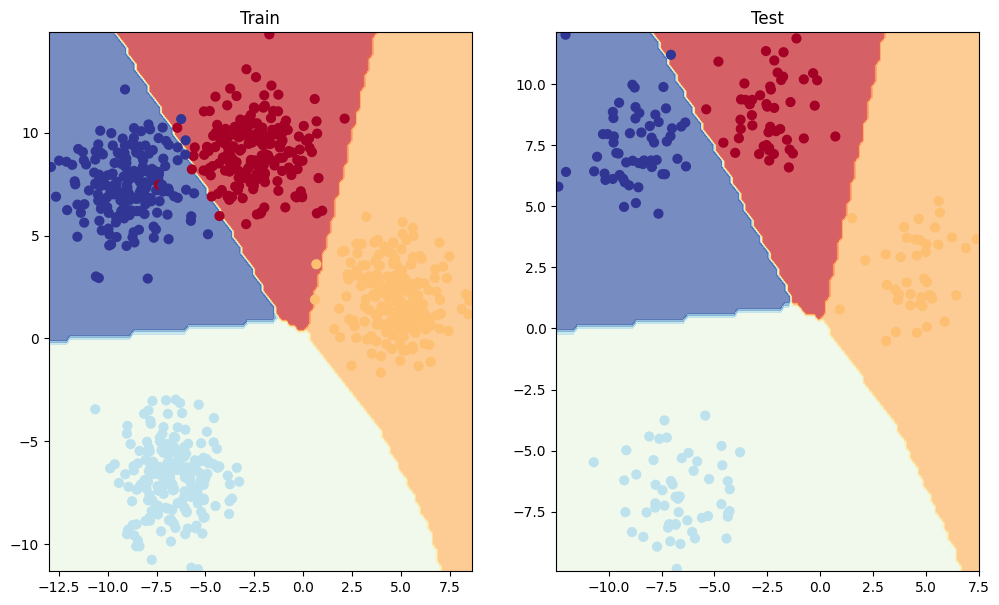

In [123]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics (to evaluate classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [127]:
from torchmetrics import Accuracy
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises & Extra curriculum

visit: https://www.learnpytorch.io/02_pytorch_classification/#exercises

# PyTorch Computer Vision 
continued in part 3 notebook